# RL Personal Assignment - LIU Dayu

In [1]:
import os, sys
import gymnasium as gym
import time
import text_flappy_bird_gym
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

D:\Anacoda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Env test

In [2]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)
    print("obs:",obs)
    print("reward:",reward)
    print("info:",info)
    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())

    # If player is dead break
    if done:
        break

env.close()


obs: (12, -1)
reward: 1
info: {'score': 0, 'player': [6, 6], 'distance': 12.041594578792296}
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[      @             ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-1)
obs: (11, 0)
reward: 1
info: {'score': 0, 'player': [6, 7], 'distance': 11.0}
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[       

# Expected Sarsa

In [3]:
class ExpectedSarsaAgent():
    def __init__(self, agent_init_info, Q):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = Q

        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        if state not in  self.q:
            self.q[state] = np.zeros(self.num_actions)

        current_q = self.q.get(state,np.zeros(self.num_actions))
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        if state not in  self.q:
            self.q[state] = np.zeros(self.num_actions)
        
        current_q = self.q.get(state,np.zeros(self.num_actions))
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update (~5 lines)
        policy = np.array(self.num_actions * [self.epsilon/self.num_actions])
        best_action = self.argmax(current_q)
        policy[best_action] = policy[best_action] + 1 - self.epsilon
        self.q[self.prev_state][self.prev_action] = self.q[self.prev_state][self.prev_action]  + self.step_size * (reward + self.discount * np.dot(policy,current_q) - self.q[self.prev_state][self.prev_action])

        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode (1 line)
        self.q[self.prev_state][self.prev_action]  = self.q[self.prev_state][self.prev_action] + self.step_size * (reward  - self.q[self.prev_state][self.prev_action])

        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

# Q-Learning

In [4]:
class QLearningAgent():
    def __init__(self, agent_init_info, Q):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        #self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])

        self.q = Q 

        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """

        if state not in  self.q:
            self.q[state] = np.zeros(self.num_actions)
        current_q = self.q.get(state,np.zeros(self.num_actions))
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        if state not in  self.q:
            self.q[state] = np.zeros(self.num_actions)
        
        current_q = self.q.get(state,np.zeros(self.num_actions))
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update (1 line)
        ### START CODE HERE ###
        self.q[self.prev_state][self.prev_action] = self.q[self.prev_state][self.prev_action] + self.step_size * (reward + self.discount * np.max(current_q) - self.q[self.prev_state][self.prev_action])
        ### END CODE HERE ###
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode (1 line)
        ### START CODE HERE ###
        self.q[self.prev_state][self.prev_action]  = self.q[self.prev_state][self.prev_action] + self.step_size * (reward  - self.q[self.prev_state][self.prev_action])
        ### END CODE HERE ###
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

# Learning Function Defination

In [5]:
def learning_with_early_stop_log_decay(max_score, max_episode, max_time, forward_reward, death_reward, decay_factor, min_epsilon,low_penalty=False,log_decay=False,screen_v0=False):
    start_time=time.time()
    org_decay=decay_factor
    best_score=0
    for episode in tqdm(range(max_episode)):
        if best_score>max_score:
            break
        else:
            init_obs = env.reset()
            obs = init_obs[0]
            if screen_v0:
                obs=obs.tobytes()
            agent.agent_start(obs)
            sum_reward = 0
            reward=0
            score = 0
            #log_decay after achieving 80
            if best_score>80 and log_decay:
                decay_factor=org_decay-((np.log(best_score))/300)
            #max between epsilon and min epsilon
            agent.epsilon = max(agent.epsilon * decay_factor, min_epsilon)
            epsilon_list.append((best_score,agent.epsilon))
            
            while True:
                action=agent.agent_step(reward,obs)
                obs, reward, done, _, info = env.step(action)
                if screen_v0:
                    obs=obs.tobytes()
                if info['score'] > score:
                    score = info['score']
                    
                    # best forward reward
                    if (score>best_score):
                        best_score=info['score']
                        reward += forward_reward
                        
                sum_reward += reward
                
                #if score achieve max score or time reach the limit, stop
                if (score>max_score) or (time.time()-start_time>max_time):
                    agent.agent_end(reward)
                    rewards_list.append(sum_reward)
                    scores.append(info['score'])
                    break
                    
                if done:
                    #low performance penalty
                    if (best_score>100) and (score<(best_score/10)) and low_penalty:
                        reward -= best_score/10
                        sum_reward -= best_score/10
                        
                    #death reward
                    sum_reward+=death_reward
                    #reward=-20
                    agent.agent_end(reward)
                    rewards_list.append(sum_reward)
                    scores.append(info['score'])
                    break

# Training on Both Agent, with best settings

In [249]:
"""
ES and QL agent on simple env
"""
agent_info = {"num_actions": 2, "epsilon": 0.2, "step_size": 0.5, "discount": 0.9,"seed": 0}
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
final_score_list=[]
final_epsilon_list=[]
final_Q_list=[]
for ag in ['ql','es']:
    Q={}
    if ag=='es':
        agent = ExpectedSarsaAgent(agent_info,Q)
    if ag=='ql':
        agent = QLearningAgent(agent_info,Q)
    rewards_list = []
    epsilon_list=[]
    scores = []
    start_time=time.time()
    learning_with_early_stop_log_decay(max_score=20000, max_episode=200000,max_time=200,forward_reward=5,death_reward=0,decay_factor=0.999,min_epsilon=1e-7,low_penalty=True,log_decay=True,screen_v0=False)
    print(f"agent{ag},used time:",time.time()-start_time)
    final_score_list.append(scores)
    final_epsilon_list.append(epsilon_list)
    final_Q_list.append(agent.q)

  1%|▌                                                                         | 1464/200000 [01:11<2:41:21, 20.51it/s]


agentql,used time: 71.39339566230774


  1%|▌                                                                         | 1410/200000 [00:44<1:43:53, 31.86it/s]

agentes,used time: 44.260756969451904


# Plot on Results

Text(0.5, 1.0, 'Log scaled best score and epsilon for simple enviroment, with modified reward and log epsilon decay')

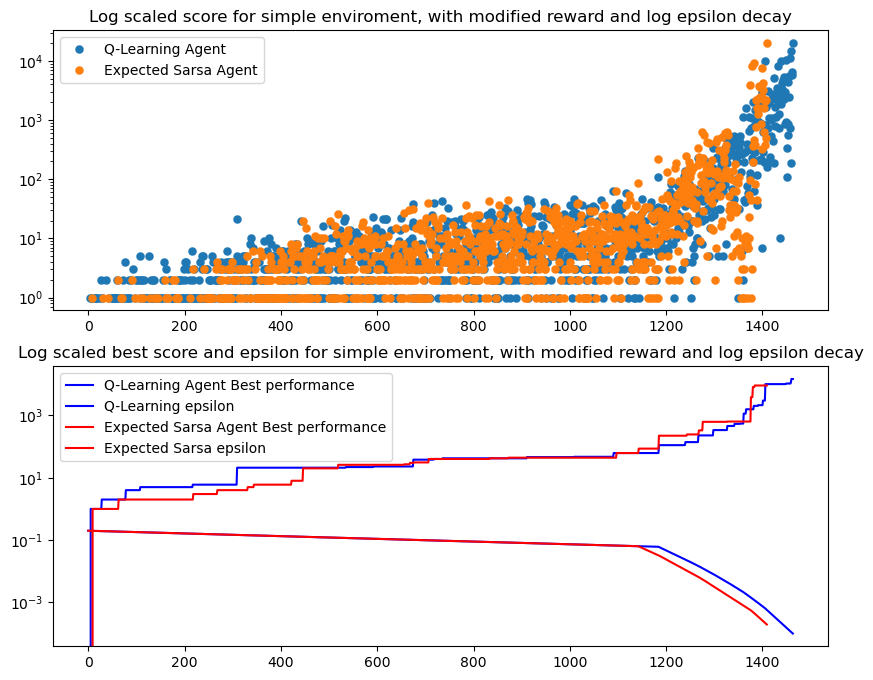

In [268]:
plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)
plt.plot(final_score_list[0], linestyle='None',marker = 'o',markeredgewidth =0.1)  
plt.plot(final_score_list[1], linestyle='None',marker = 'o',markeredgewidth =0.1)  
plt.yscale('log')
plt.legend(['Q-Learning Agent','Expected Sarsa Agent'])
plt.title(f"Log scaled score for simple enviroment, with modified reward and log epsilon decay")
plt.subplot(2, 1, 2)
plt.plot(final_epsilon_list[0],color='b')  
plt.plot(final_epsilon_list[1],color='red')  
plt.yscale('log')
plt.legend(['Q-Learning Agent Best performance','Q-Learning epsilon','Expected Sarsa Agent Best performance','Expected Sarsa epsilon'])
plt.title(f"Log scaled best score and epsilon for simple enviroment, with modified reward and log epsilon decay")

# Value Function Plot

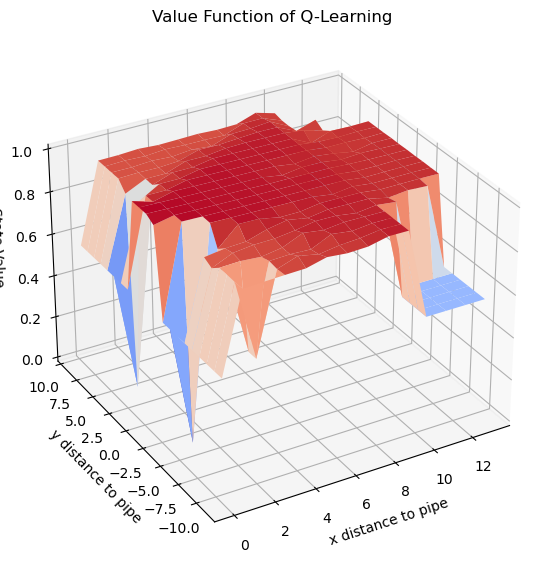

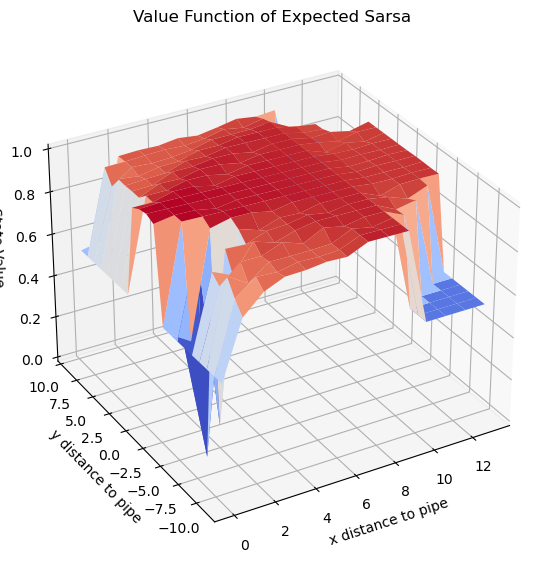

In [260]:
"""
value function plot
"""
for qvalue in final_Q_list:
    fig = plt.figure(figsize=(15, 15))
    V = {k:np.max(v) for k, v in qvalue.items()}
    x_range=range(14)
    y_range=range(-11,10)
    X, Y = np.meshgrid(x_range, y_range)
    # np.ravel(X)
    Z = np.array([V[(x,y)] if (x,y) in V else -100 for x,y in zip(np.ravel(X), np.ravel(Y)) ]).reshape(X.shape)
    Z = (Z-np.min(Z))/(np.max(Z)-np.min(Z))

    ax = fig.add_subplot(211, projection='3d')
    ax.set_title(f"Value Function of {['Q-Learning','Expected Sarsa'][final_Q_list.index(qvalue)]}")
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm)
    ax.set_xlabel('x distance to pipe')
    ax.set_ylabel('y distance to pipe')
    ax.set_zlabel('State Value')
    ax.view_init(ax.elev, -120)

# Decision Policy plot

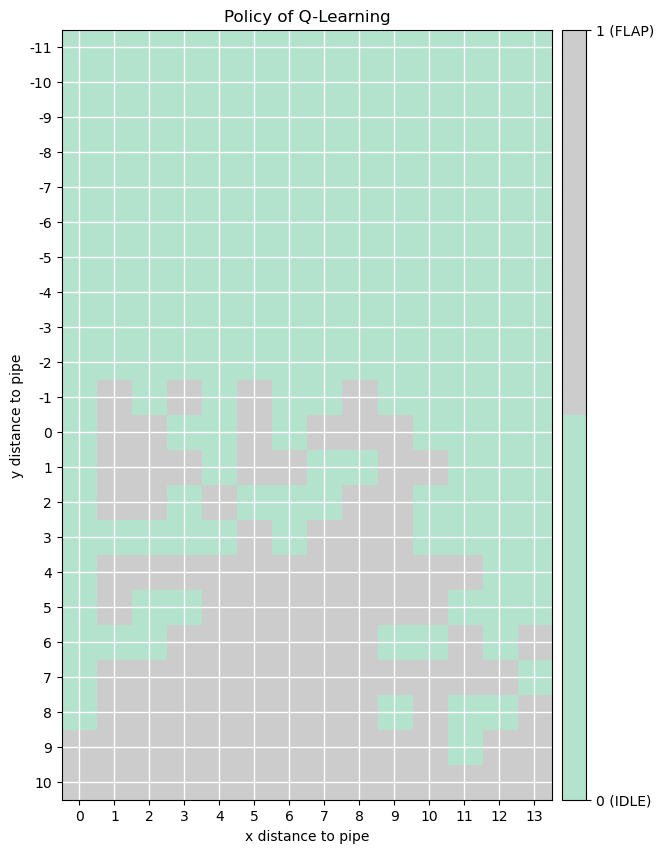

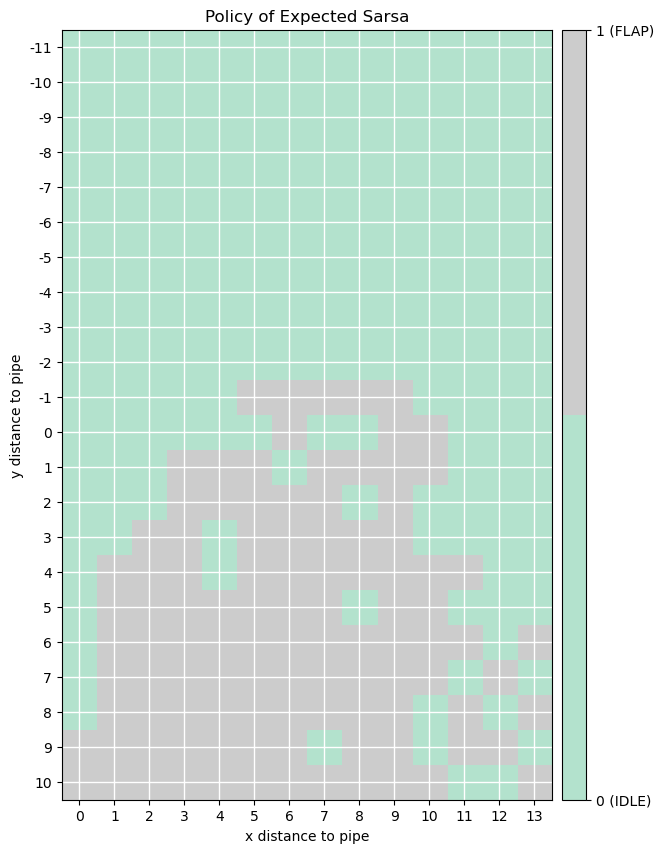

In [300]:

for qq in final_Q_list: 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.set_title(f"Policy of {['Q-Learning','Expected Sarsa'][final_Q_list.index(qq)]}")
    x_range = np.arange(0, 14,1)
    y_range = np.arange(0, 22,1)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.array([[np.argmax(qq[x,y]) if (x,y) in qq else 0 for x in x_range] for y in y_range])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2))
    plt.xticks(x_range)
    plt.yticks(y_range)
    plt.gca().invert_yaxis()
    ax.set_xlabel('x distance to pipe')
    ax.set_ylabel('y distance to pipe')
    ax.grid(color='w', linestyle='-', linewidth=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
    cbar.ax.set_yticklabels(['0 (IDLE)','1 (FLAP)'])
    ax.set_yticks(np.arange(22),np.arange(-11,11)[::-1])

# Play on Trained Agent

In [62]:
init_obs = env.reset()
obs = init_obs[0]
reward = 0
agent.agent_start(obs)
sum_reward = reward
score = 0
agent.epsilon=1e-7
while True:
    action = agent.agent_step(reward,obs)  
    obs, reward, done, _, info = env.step(action)
    if info['score'] > score:
        score = info['score']

    if done:
        sum_reward += reward
        #only show dead agent
        os.system("clear")
        sys.stdout.write(env.render())
        agent.agent_end(reward)
        break

Text Flappy Bird!
Score: 24570
----------------------
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[                |   ]
[                    ]
[                    ]
[                    ]
[      |             ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[     *|         |   ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=0,dy=7)


# Parameter Testing - Epsilon and Step Size

In [19]:
"""
number of run per case: 3
agent: es, ql
without epsilon decay, reward change, log decay...
test parameter:epsilon, step size
"""
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
result={}
num_run=1
for ag in ['ES','QL']:
    for epsil in [0,0.01,0.1,0.5]:
        for stepsize in [0.01,0.1,0.5,1]:
            sum_time=[]
            highest_score=[]
            for n in range(num_run):
                agent_info = {"num_actions": 2, "epsilon": epsil, "step_size": stepsize, "discount": 0.9,"seed": 0}
                Q={}
                if ag=='ES':
                    agent = ExpectedSarsaAgent(agent_info,Q)
                if ag=='QL':
                    agent = QLearningAgent(agent_info,Q)
                starttime=time.time() 
                rewards_list = []
                epsilon_list=[]
                scores = []
                learning_with_early_stop_log_decay(max_score=5000, max_episode=20000,max_time=150,forward_reward=0,death_reward=0,decay_factor=1,min_epsilon=0,low_penalty=False,log_decay=False)
                sum_time.append(time.time()-start_time)
                highest_score.append(scores)
            result[f'{ag}_{epsil}_{stepsize}']=(sum_time,highest_score)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:08<00:00, 2487.20it/s]


Text(0.5, 1.0, 'Expected Sarsa and Q Learning agent in different epsilon and stepsize (100+ score only)')

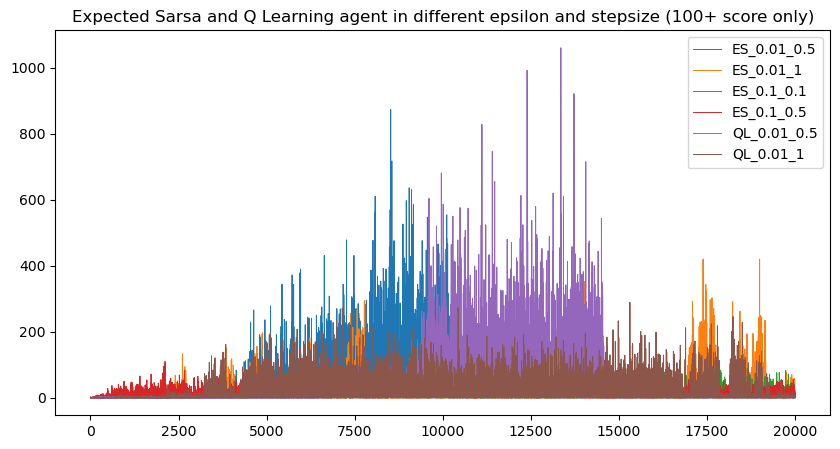

In [28]:
plt.figure(figsize=(10,5))
plot_list=[n for n in result.keys() if max(result[n][1][0])>100]
for key in result.keys():
    if max(result[key][1][0])>100:
        plt.plot(result[key][1][0],linewidth=0.7)
plt.legend(plot_list)
plt.title('Expected Sarsa and Q Learning agent in different epsilon and stepsize (100+ score only)')

# Parameter Testing - Discount

In [12]:
"""
number of run per case: 3
agent: es, ql
without epsilon decay, reward change, log decay...
test parameter: discount
"""
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
discount_result={}
num_run=3
for ag in ['ES','QL']:
    for disc in [1,0.99,0.9,0.5]:
        sum_time=[]
        highest_score=[]
        for n in range(num_run):
            agent_info = {"num_actions": 2, "epsilon": 0.01, "step_size": 0.5, "discount": disc,"seed": 0}
            Q={}
            if ag=='ES':
                agent = ExpectedSarsaAgent(agent_info,Q)
            if ag=='QL':
                agent = QLearningAgent(agent_info,Q)
            starttime=time.time() 
            rewards_list = []
            epsilon_list=[]
            scores = []
            learning_with_early_stop_log_decay(max_score=5000, max_episode=20000,max_time=180,forward_reward=0,death_reward=0,decay_factor=1,min_epsilon=0,low_penalty=False,log_decay=False)
            sum_time.append(time.time()-start_time)
            highest_score.append(scores)
        discount_result[f'{ag}_{disc}']=(sum_time,highest_score)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:12<00:00, 274.58it/s]


Text(0.5, 1.0, 'Expected Sarsa and Q Learning agent in different discount')

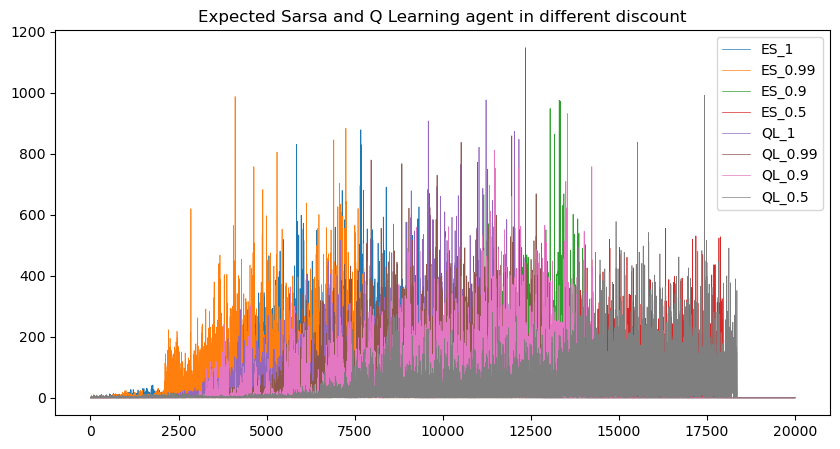

In [18]:
plt.figure(figsize=(10,5))
for key in discount_result.keys():
    plt.plot(discount_result[key][1][0],linewidth=0.5)
plt.legend(discount_result.keys())
plt.title('Expected Sarsa and Q Learning agent in different discount')

# Experiment on Epsilon Decay Strategy and Reward Function

In [88]:
"""
comparsion between fixed epsilon, fixed epsilon decay and flexible epsilon decay - score and epsilon plot
"""

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
es_final_score_list=[]
es_final_epsilon_list=[]
ql_final_score_list=[]
ql_final_epsilon_list=[]
for ag in ['ES','QL']:
    if ag=='ES':
#         agent = ExpectedSarsaAgent(agent_info,Q)
        agen = ExpectedSarsaAgent
    if ag=='QL':
#         agent = QLearningAgent(agent_info,Q)
        agen = QLearningAgent
    for stage in ['fixed_e','fixed_d_rate','flexible_d_rate with modified reward']:
        Q={}
        rewards_list = []
        epsilon_list=[]
        scores = []
        start_time=time.time()
        if stage=='fixed_e':
            agent_info = {"num_actions": 2, "epsilon": 0.01, "step_size": 0.5, "discount": 0.9,"seed": 0}
            agent=agen(agent_info,Q)
            learning_with_early_stop_log_decay(max_score=10000, max_episode=20000,max_time=600,forward_reward=0,death_reward=0,decay_factor=1,min_epsilon=1e-7,low_penalty=False,log_decay=False,screen_v0=False)
        if stage=='fixed_d_rate':
            agent_info = {"num_actions": 2, "epsilon": 0.1, "step_size": 0.5, "discount": 0.9,"seed": 0}
            agent=agen(agent_info,Q)
            learning_with_early_stop_log_decay(max_score=10000, max_episode=20000,max_time=600,forward_reward=0,death_reward=0,decay_factor=0.999,min_epsilon=1e-7,low_penalty=False,log_decay=False,screen_v0=False)
        if stage=='flexible_d_rate with modified reward':
            agent_info = {"num_actions": 2, "epsilon": 0.1, "step_size": 0.5, "discount": 0.9,"seed": 0}
            agent=agen(agent_info,Q)
            learning_with_early_stop_log_decay(max_score=10000, max_episode=20000,max_time=600,forward_reward=5,death_reward=0,decay_factor=0.999,min_epsilon=1e-7,low_penalty=True,log_decay=True,screen_v0=False)
        if ag=='ES':
            es_final_score_list.append(scores)
            es_final_epsilon_list.append(epsilon_list)
        if ag=='QL':
            ql_final_score_list.append(scores)
            ql_final_epsilon_list.append(epsilon_list)

  8%|█████▉                                                                      | 1572/20000 [00:15<03:03, 100.37it/s]


Text(0.5, 1.0, 'Best performance and according epsilons of Expected Sarsa ')

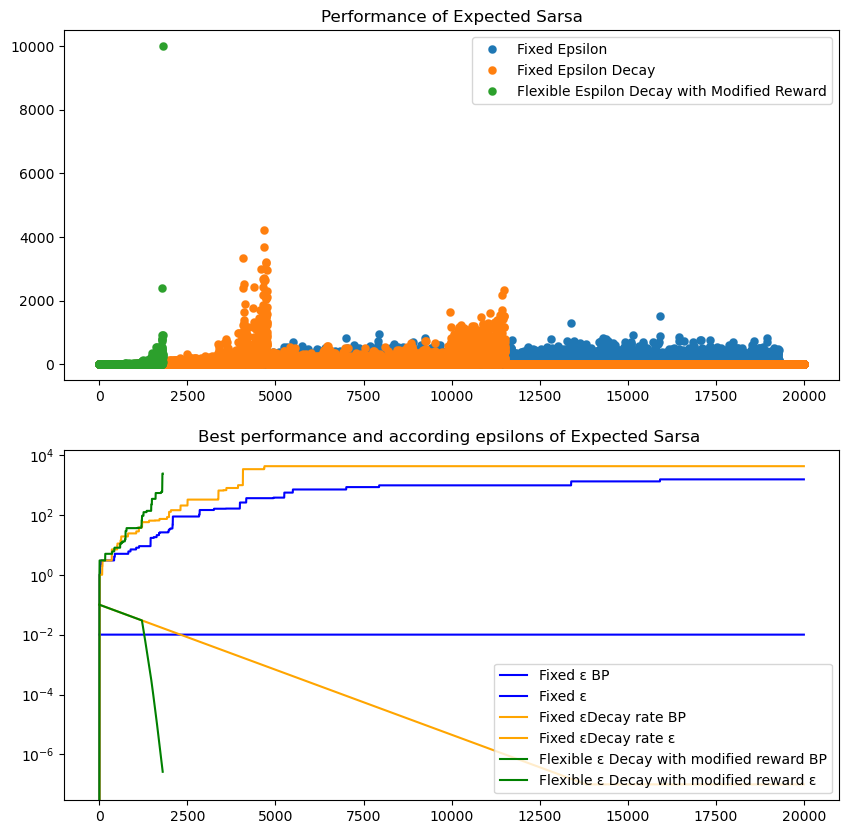

In [106]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(es_final_score_list[0], linestyle='None',marker = 'o',markeredgewidth =0.1)  
plt.plot(es_final_score_list[1], linestyle='None',marker = 'o',markeredgewidth =0.1)  
plt.plot(es_final_score_list[2], linestyle='None',marker = 'o',markeredgewidth =0.1)   
plt.yscale('linear')
plt.legend(['Fixed Epsilon','Fixed Epsilon Decay','Flexible Espilon Decay with Modified Reward'])
plt.title(f"Performance of Expected Sarsa")
plt.subplot(2, 1, 2)
plt.plot(es_final_epsilon_list[0],color='b')  
plt.plot(es_final_epsilon_list[1],color='orange')
plt.plot(es_final_epsilon_list[2],color='g')    
plt.yscale('log')
plt.legend(['Fixed ε BP','Fixed ε','Fixed εDecay rate BP','Fixed εDecay rate ε','Flexible ε Decay with modified reward BP','Flexible ε Decay with modified reward ε'],loc=4)
plt.title(f"Best performance and according epsilons of Expected Sarsa ")

Text(0.5, 1.0, 'Best performance and according epsilons of Q-learning')

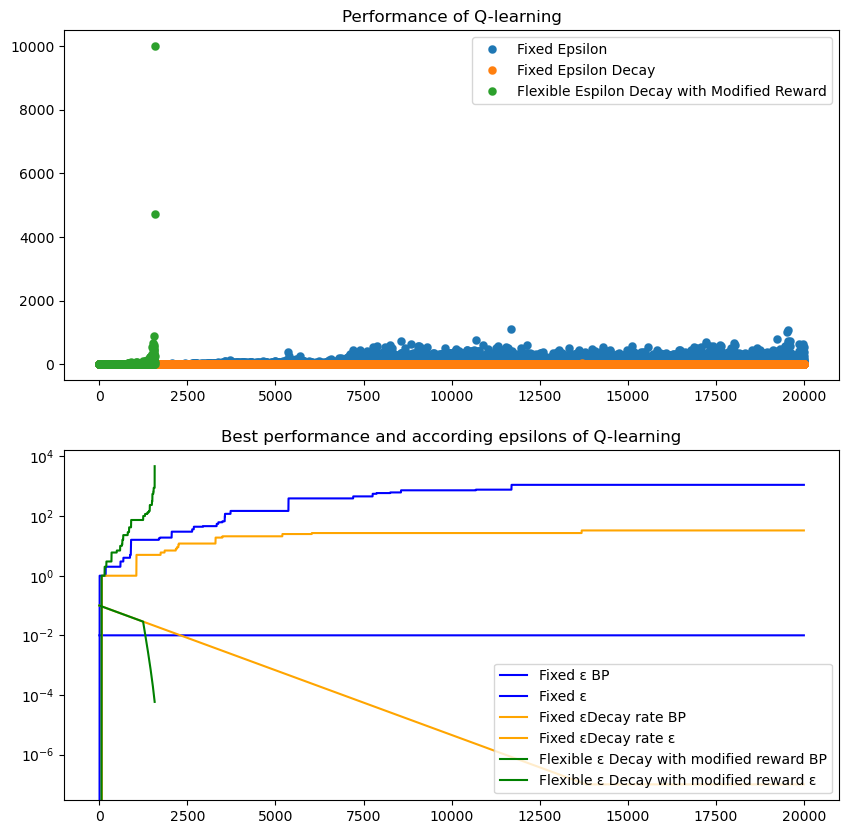

In [107]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(ql_final_score_list[0], linestyle='None',marker = 'o',markeredgewidth =0.1)  
plt.plot(ql_final_score_list[1], linestyle='None',marker = 'o',markeredgewidth =0.1)  
plt.plot(ql_final_score_list[2], linestyle='None',marker = 'o',markeredgewidth =0.1)   
plt.yscale('linear')
plt.legend(['Fixed Epsilon','Fixed Epsilon Decay','Flexible Espilon Decay with Modified Reward'])
plt.title(f"Performance of Q-learning")
plt.subplot(2, 1, 2)
plt.plot(ql_final_epsilon_list[0],color='b')  
plt.plot(ql_final_epsilon_list[1],color='orange')
plt.plot(ql_final_epsilon_list[2],color='g')    
plt.yscale('log')
plt.legend(['Fixed ε BP','Fixed ε','Fixed εDecay rate BP','Fixed εDecay rate ε','Flexible ε Decay with modified reward BP','Flexible ε Decay with modified reward ε'],loc=4)
plt.title(f"Best performance and according epsilons of Q-learning")

# Attempt on Screen Environment

In [108]:
"""
ES and QL agent on screen env
"""
agent_info = {"num_actions": 2, "epsilon": 0.2, "step_size": 0.5, "discount": 0.9,"seed": 0}
env = gym.make('TextFlappyBird-screen-v0', height = 15, width = 20, pipe_gap = 4)
final_score_list=[]
final_epsilon_list=[]
for ag in ['ql','es']:
    Q={}
    if ag=='es':
        agent = ExpectedSarsaAgent(agent_info,Q)
    if ag=='ql':
        agent = QLearningAgent(agent_info,Q)
    rewards_list = []
    epsilon_list=[]
    scores = []
    start_time=time.time()
    learning_with_early_stop_log_decay(max_score=10000, max_episode=1000000,max_time=2000,forward_reward=5,death_reward=0,decay_factor=0.99999,min_epsilon=1e-6,low_penalty=True,log_decay=True,screen_v0=True)
    print(f"agent{ag},used time:",time.time()-start_time)
    final_score_list.append(scores)
    final_epsilon_list.append(epsilon_list)

  7%|████▉                                                                   | 69162/1000000 [25:14<5:39:40, 45.67it/s]


agentql,used time: 1514.2948069572449


  6%|████▎                                                                   | 60048/1000000 [25:30<6:39:16, 39.24it/s]

agentes,used time: 1530.4248337745667


Text(0.5, 1.0, 'Log scaled best score and epsilon for screen enviroment, with modified reward and log epsilon decay')

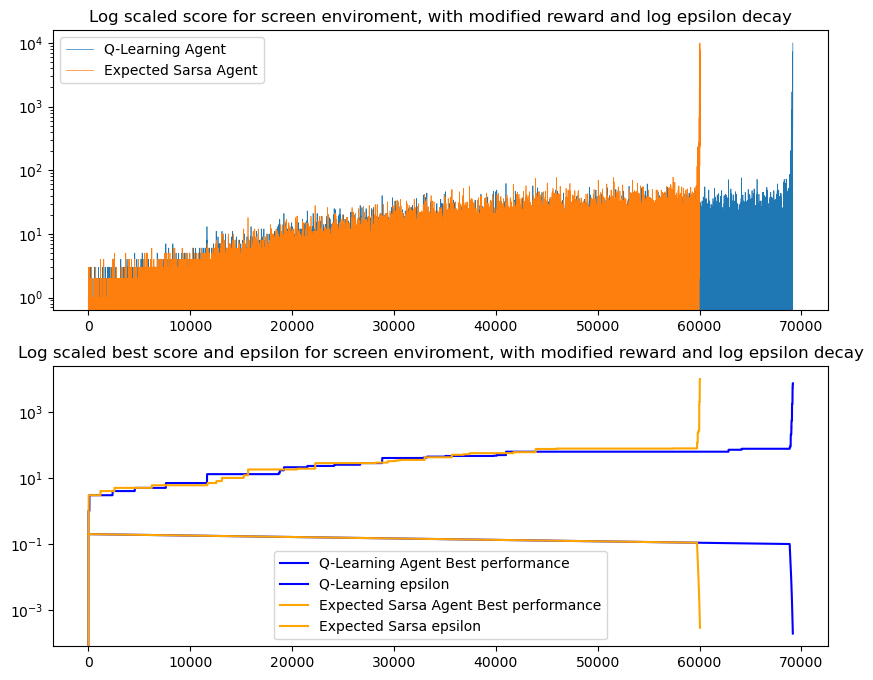

In [113]:
plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)
plt.plot(final_score_list[0],linewidth=0.5)  
plt.plot(final_score_list[1],linewidth=0.5)  
plt.yscale('log')
plt.legend(['Q-Learning Agent','Expected Sarsa Agent'])
plt.title(f"Log scaled score for screen enviroment, with modified reward and log epsilon decay")
plt.subplot(2, 1, 2)
plt.plot(final_epsilon_list[0],color='b')  
plt.plot(final_epsilon_list[1],color='orange')  
plt.yscale('log')
plt.legend(['Q-Learning Agent Best performance','Q-Learning epsilon','Expected Sarsa Agent Best performance','Expected Sarsa epsilon'])
plt.title(f"Log scaled best score and epsilon for screen enviroment, with modified reward and log epsilon decay")

# Attempt on Original Environment

In [224]:
def FB_learning_with_early_stop_log_decay(max_score, max_episode, max_time, forward_reward, death_reward, decay_factor, min_epsilon,low_penalty=False,log_decay=False,screen_v0=False):
    start_time=time.time()
    org_decay=decay_factor
    best_score=0
    for episode in tqdm(range(max_episode)):
        if best_score>max_score:
            break
        else:
            init_obs = env.reset()
            obs = init_obs
            if screen_v0:
                obs=np.array([obs[0]//0.1,obs[1]//0.1]).tobytes()
            agent.agent_start(obs)
            sum_reward = 0
            reward=0
            score = 0
            #log_decay after achieving 80
            if best_score>80 and log_decay:
                decay_factor=org_decay-((np.log(best_score))/300)
            #max between epsilon and min epsilon
            agent.epsilon = max(agent.epsilon * decay_factor, min_epsilon)
            epsilon_list.append((best_score,agent.epsilon))
            ttttt=0
            while True:
                ttttt+=1
                if ttttt%5==0:
                    action=agent.agent_step(reward,obs)
                else:
                    action=0
                obs, reward, done, info = env.step(action)
                if screen_v0:
                    obs=np.array([obs[0]//0.1,obs[1]//0.1]).tobytes()
                if info['score'] > score:
                    score = info['score']

                    # best forward reward
                    if (score>best_score):
                        best_score=info['score']
                        reward += forward_reward
                        print(f"new best {best_score} in episode{episode}")
                sum_reward += reward

                #if score achieve max score or time reach the limit, stop
                if (score>max_score) or (time.time()-start_time>max_time):
                    agent.agent_end(reward)
                    rewards_list.append(sum_reward)
                    scores.append(info['score'])
                    break

                if done:
                    #low performance penalty
                    if (best_score>100) and (score<(best_score/10)) and low_penalty:
                        reward -= best_score/10
                        sum_reward -= best_score/10

                    #death reward
                    sum_reward+=death_reward
                    agent.agent_end(reward)
                    rewards_list.append(sum_reward)
                    scores.append(info['score'])
                    break

In [225]:
import flappy_bird_gym
env = flappy_bird_gym.make("FlappyBird-v0")
agent_info = {"num_actions": 2, "epsilon": 0.1, "step_size": 0.5, "discount": 0.9,"seed": 0}

Q={}
agent = QLearningAgent(agent_info,Q)
rewards_list = []
epsilon_list=[]
scores = []
start_time=time.time()
FB_learning_with_early_stop_log_decay(max_score=10000, max_episode=1000000,max_time=3000,forward_reward=5,death_reward=0,decay_factor=0.99999,min_epsilon=1e-6,low_penalty=True,log_decay=True,screen_v0=True)
print(f"agent{ag},used time:",time.time()-start_time)

  0%|                                                                           | 345/1000000 [00:00<25:07, 663.33it/s]

new best 1 in episode259


  0%|                                                                           | 541/1000000 [00:00<26:38, 625.32it/s]

new best 2 in episode453
new best 3 in episode483


  0%|                                                                           | 667/1000000 [00:01<30:20, 548.98it/s]

new best 4 in episode619
new best 5 in episode654
new best 6 in episode654


  0%|                                                                           | 880/1000000 [00:01<33:34, 496.04it/s]

new best 7 in episode752
new best 8 in episode752


  0%|▏                                                                         | 1866/1000000 [00:03<32:04, 518.71it/s]

new best 9 in episode1773


  0%|▏                                                                         | 2718/1000000 [00:05<33:03, 502.71it/s]

new best 10 in episode2630


  3%|█▉                                                                       | 26506/1000000 [00:52<32:17, 502.49it/s]

new best 11 in episode26422
new best 12 in episode26422


  5%|███▌                                                                     | 49583/1000000 [01:39<32:53, 481.57it/s]

new best 13 in episode49488
new best 14 in episode49488
new best 15 in episode49488
new best 16 in episode49488
new best 17 in episode49488
new best 18 in episode49488


 29%|█████████████████████▏                                                  | 293878/1000000 [10:55<28:26, 413.86it/s]

new best 19 in episode293793


 48%|██████████████████████████████████▌                                     | 480107/1000000 [18:31<20:03, 432.10it/s]


KeyboardInterrupt: 